# Scikit-downscale

## Prepare models

This first cell just imports some libraries and get's things setup for our analysis to come.This first cell just imports some libraries and get's things setup for our analysis to come.

In [1]:
# close warming info
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import numpy as np

from utils import get_sample_data

sns.set(style='darkgrid')

In the cell below, we'll create nine different downscaling models, some from Scikit-downscale and some from Scikit-learn.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation
from skdownscale.pointwise_models import QuantileMappingReressor

models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0),
    'GARD: QuantileMappingRegressor': QuantileMappingReressor()
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')


## Activate CUPs for parallel computing

Step 1: Start a Dask Cluster. Xarray and the `PointWiseDownscaler` will make use of this cluster when it comes time to load input data and train/predict downscaling models. 

In [3]:
from dask.distributed import Client

client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/net/wrfstore7-10/disk1/sw1013/SINGAPORE/scikit-downscale/examples/dask-worker-space/worker-i5mg3073', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/wrfstore7-10/disk1/sw1013/SINGAPORE/scikit-downscale/examples/dask-worker-space/worker-3nkl2wox', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/wrfstore7-10/disk1/sw1013/SINGAPORE/scikit-downscale/examples/dask-worker-space/worker-03ubnzj0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/wrfstore7-10/disk1/sw1013/SINGAPORE/scikit-downscale/examples/dask-worker-space/worker-xk2fiwlj', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/wrfstore7-10/disk1/sw1013/SINGAPORE/scikit-downscale/examples/dask-worker-space/worker-07oum6d8', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/wrfstore7-10/disk1/sw1013/SINGAP

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 188.74 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38040,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 188.74 GiB
Comm: tcp://146.179.44.31:44114,Total threads: 4
Dashboard: http://146.179.44.31:39401/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:40012,


## Make a choice of the downscale model

In [4]:
from skdownscale.pointwise_models import PointWiseDownscaler
from dask.diagnostics import ProgressBar

# model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))
# model = PointWiseDownscaler(RandomForestRegressor(random_state=0))
# model = PointWiseDownscaler(PureAnalog(kind='best_analog', n_analogs=1))
# model = PointWiseDownscaler(PureAnalog(kind='sample_analogs', n_analogs=10))
model = PointWiseDownscaler(QuantileMappingReressor())

model

<skdownscale.PointWiseDownscaler>
  Fit Status: False
  Model:
    QuantileMappingReressor()

## Malaysia/Philippines/Thailand/Indonesia

In [5]:
# parameters
train_slice = slice('2005', '2007')  # train time range   '1981', '1983'
holdout_slice = slice('2053', '2055')  # prediction time range

CITY_CENTER = pd.DataFrame(data={
    'CITY': ['KUALA_LUMPUR','MANILA','BANGKOK','JAKARDA'],
    'LAT' : [3.08  , 14.60 ,13.76 , -6.21 ],
    'LON' : [101.67, 120.99,100.49, 106.81]
                               })
# Malaysia
#NNN,SSS,WWW,EEE = 8.5,-0.5,98.5,120.5

# Philippines
# NNN,SSS,WWW,EEE = 23.5,3.5,115.5,128.5

# Thailand
# NNN,SSS,WWW,EEE = 21.5, 4.5, 96.5, 106.5

# Indonesia
# NNN,SSS,WWW,EEE = 6.5, -12.5, 94.5, 142.5

NNN,SSS,WWW,EEE = CITY_CENTER[CITY_CENTER.CITY=='BANGKOK'].values[0][1]+2, \
                  CITY_CENTER[CITY_CENTER.CITY=='BANGKOK'].values[0][1]-2, \
                  CITY_CENTER[CITY_CENTER.CITY=='BANGKOK'].values[0][2]-2, \
                  CITY_CENTER[CITY_CENTER.CITY=='BANGKOK'].values[0][2]+2

# bounding box of downscaling region
lon_slice = slice(WWW, EEE) 
lat_slice = slice(NNN, SSS)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [6]:
import ee
import wxee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

# singapore: 1.3521° N, 103.8198° E
region = ee.Geometry.Polygon([[
    [WWW, NNN],
    [WWW, SSS],
    [EEE, SSS],
    [EEE, NNN]
]])
era5_2mt = ee.ImageCollection('ECMWF/ERA5/DAILY')
era5_2mt = era5_2mt.select('maximum_2m_air_temperature')
era5_2mt = era5_2mt.filterDate("2005-01-01", "2008-01-01") # here we should add one more time for the end point
obs_subset=era5_2mt.wx.to_xarray(region=region)
obs_subset=obs_subset['maximum_2m_air_temperature']

xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=wjT8S0jwDNROi3ms_TFJYtIX1LAPq1ZNintvTsFYI8o&code_challenge_method=S256'


Enter verification code:  4/1AX4XfWh28KkpUirqPjg9rsCRnbUgFxANOHW8y_DultFXwIGcG8XuyCFewSI



Successfully saved authorization token.


Requesting data:   0%|          | 0/1095 [00:00<?, ?it/s]

In [7]:
obs_subset=obs_subset.rename({'x': 'lon','y': 'lat'})

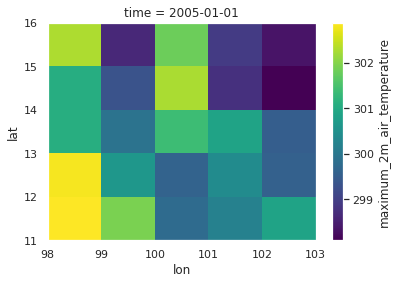

In [8]:
obs_subset.isel(time=0).plot()

Set the downscale resolution here. Example: CHANGE_INTERVAL=0.02 is for a resolution of 1deg*0.02~2km

In [9]:
CHANGE_INTERVAL=0.01#0.005
obs_subset = obs_subset.interp(lat=np.arange(NNN, SSS-CHANGE_INTERVAL,-CHANGE_INTERVAL),lon=np.arange(WWW, EEE+CHANGE_INTERVAL,CHANGE_INTERVAL),kwargs={"fill_value": "extrapolate"})
# obs_subset.interp(lat=np.arange(NNN, SSS-CHANGE_INTERVAL,-CHANGE_INTERVAL),lon=np.arange(WWW, EEE+CHANGE_INTERVAL,CHANGE_INTERVAL)).isel(time=0).plot()

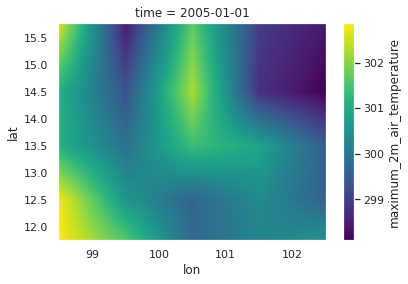

In [10]:
obs_subset.isel(time=0).plot()

Load our training/prediction data.

/home/sw1013/anaconda3/envs/downscale/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/sw1013/anaconda3/envs/downscale/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/sw1013/anaconda3/envs/downscale/lib/python3.9/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


,Array,Chunk
Bytes,673.36 MiB,427.73 kiB
Shape,"(1095, 401, 402)","(1095, 10, 10)"
Count,1681 Tasks,1681 Chunks
Type,float32,numpy.ndarray


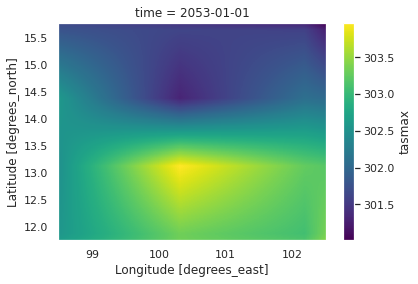

In [11]:
import intake_esm
import intake

# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
# cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
#                  grid_label='gn')
cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id='tasmax',member_id='r1i1p1f1',
                 grid_label='gn')

# access the data and do some cleanup
ds_model = cat['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

# regional subsets, ready for downscaling
train_subset = ds_model['tasmax'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
train_subset['time']=pd.to_datetime(train_subset['time'].dt.strftime('%Y-%m-%d'))
# train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)


# access the data and do some cleanup
ds_model = cat['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

holdout_subset = ds_model['tasmax'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
holdout_subset['time']=pd.to_datetime(holdout_subset['time'].dt.strftime('%Y-%m-%d'))
# holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
# display(train_subset)
# train_subset.isel(time=0).plot()
display(train_subset)
holdout_subset.isel(time=0).plot()

Check the available CMIP6 models

In [12]:
cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id='tasmax',grid_label='gn')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20181015
1,CMIP,BCC,BCC-CSM2-MR,historical,r2i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181116
2,CMIP,BCC,BCC-CSM2-MR,historical,r3i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181119
3,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
4,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
...,...,...,...,...,...,...,...,...,...,...,...
388,ScenarioMIP,MRI,MRI-ESM2-0,ssp585,r2i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ss...,NaN,20210907
389,ScenarioMIP,MRI,MRI-ESM2-0,ssp585,r3i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ss...,NaN,20210907
390,CMIP,MRI,MRI-ESM2-0,historical,r6i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210907
391,ScenarioMIP,MRI,MRI-ESM2-0,ssp585,r5i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ss...,NaN,20210907


Train the model

In [13]:
model.fit(train_subset, obs_subset)
# model.fit(train_subset, train_subset)
display(model, model._models)

<skdownscale.PointWiseDownscaler>
  Fit Status: True
  Model:
    QuantileMappingReressor()

<xarray.DataArray 'tasmax' (lat: 401, lon: 402)>
dask.array<<this-array>-_fit_wrapper, shape=(401, 402), dtype=object, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 15.76 15.75 15.74 15.73 ... 11.79 11.78 11.77 11.76
  * lon      (lon) float64 98.49 98.5 98.51 98.52 ... 102.5 102.5 102.5 102.5

Downscale into future

In [14]:
predicted = model.predict(holdout_subset).load()
nowdays = model.predict(train_subset).load()

In [15]:
predicted.to_netcdf("./OUTPUT/TEMP_BANGKOK_1km_2050.nc")
nowdays  .to_netcdf("./OUTPUT/TEMP_BANGKOK_1km_NOW.nc")

## PLOT

In [3]:
# modified from

import regionmask
import geopandas as gpd

PATH_TO_SHAPEFILE = '../../borders/gadm36.shp'
countries = gpd.read_file(PATH_TO_SHAPEFILE)

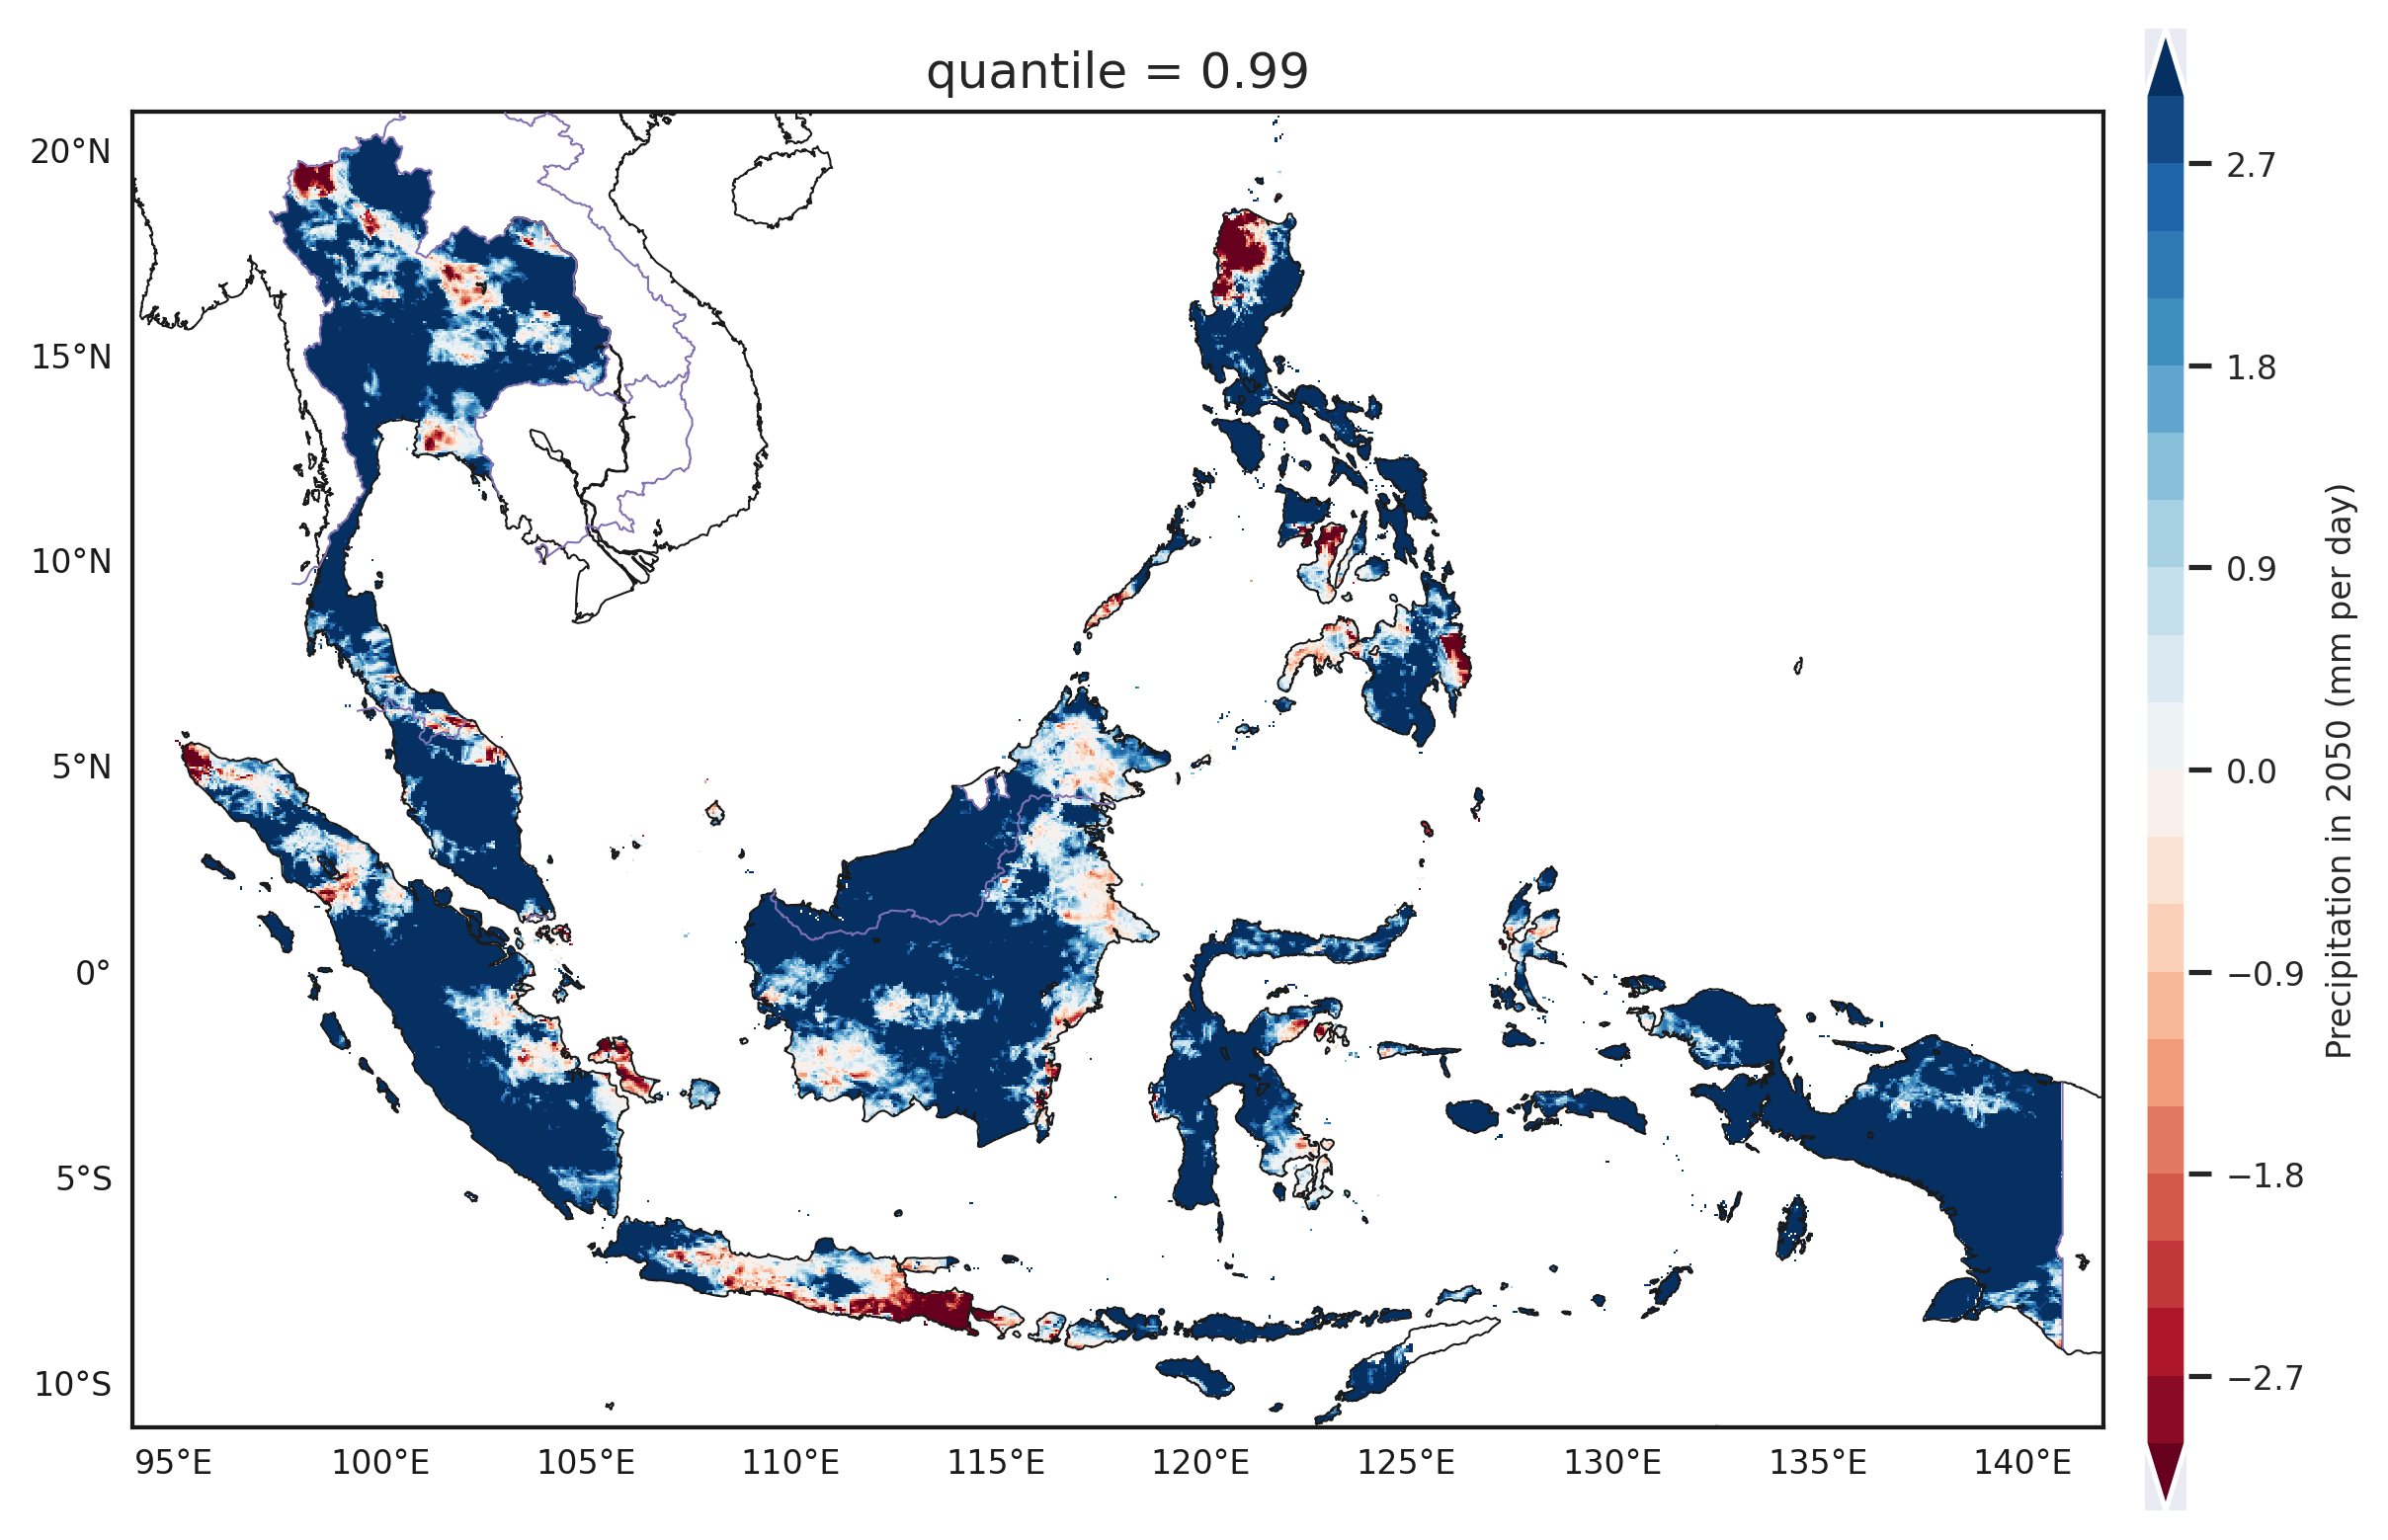

In [107]:
import xarray as xr
from   mpl_toolkits.basemap    import Basemap
from   matplotlib              import gridspec
from   matplotlib.colorbar     import Colorbar


fig,ax=plt.subplots(1,1); fig.set_size_inches(7,5); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(300); 
fig.subplots_adjust(left=0.00, right=0.95, top=1., bottom=0.0, wspace=0.4,hspace=0.3); fontsize = 8

gs0  = gridspec.GridSpec(1, 1)
gs0.update(left=0.97, right=0.99, bottom=0.00, top=1., hspace=0.06, wspace=0.1)
bx = plt.subplot(gs0[0, 0])

m = Basemap(projection='cyl', llcrnrlat=-11, urcrnrlat=21,llcrnrlon=94, urcrnrlon=142,resolution='i',ax=ax)
_ = m.drawcoastlines(linewidth=.5,color='k',zorder=10)
_ = m.drawcountries(linewidth=.5,color='m',zorder=10)
_ = m.drawmapboundary(fill_color='w')
_ = m.fillcontinents(color='none',lake_color='none')
_ = m.drawmeridians(np.arange(0,361,5),labels=[0,0,0,1],linewidth=0.,fontsize=fontsize)
_ = m.drawparallels(np.arange(-40,61,5),labels=[1,0,0,0],linewidth=0.,fontsize=fontsize)

for C_NAME in ['Malaysia','Philippines','Thailand','Indonesia']:
    
    predicted = xr.open_dataset('./OUTPUT/RAIN_'+C_NAME+'_5km_2050.nc')
    nowdays   = xr.open_dataset('./OUTPUT/RAIN_'+C_NAME+'_5km_NOW.nc')
    
    countries_select = countries[countries.NAME_0==C_NAME].geometry

    countries_mask_poly = regionmask.Regions(name = 'NAME_0', outlines = list(countries_select.geometry.values[i] for i in range(0,countries_select.shape[0])))

    mask = countries_mask_poly.mask(predicted.isel(time = 0), lat_name='lat', lon_name='lon')

    # tmp_var = predicted.mean('time')-nowdays.mean('time')
    tmp_var = predicted.quantile(0.99, dim="time")-nowdays.quantile(0.99, dim="time")
    ### we can smooth the quantilet but will lose details
    # for SMOOTH in range(1):
    #     tmp_var = tmp_var.rolling(lat=10,lon=10, center=True, min_periods=1).mean()
    tmp_var = tmp_var.where(~np.isnan(mask))
    
    # change unit from m to mm
    tmp_var = tmp_var * 1000.
    
    c=tmp_var.__xarray_dataarray_variable__.plot(ax=ax,cmap='RdBu',levels=np.linspace(-3,3,21),extend='both',add_colorbar=False,facecolor="white")
    if C_NAME == 'Malaysia':
        cb = Colorbar(ax = bx, mappable = c,orientation = 'vertical', ticklocation = 'right')
        cb.set_label('Precipitation in 2050 (mm per day)', labelpad=5,fontsize=fontsize)
        cb.ax.tick_params(labelsize=fontsize)        
        
    _=countries_select.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 0.)
    _=ax.set_xlim(94,142)
    _=ax.set_ylim(-11,21)
    _=ax.set_xlabel('')
    _=ax.set_ylabel('')

plt.savefig('/home/sw1013/www/FIGURES/SIG_PRECIP.png',dpi=600,bbox_inches='tight')

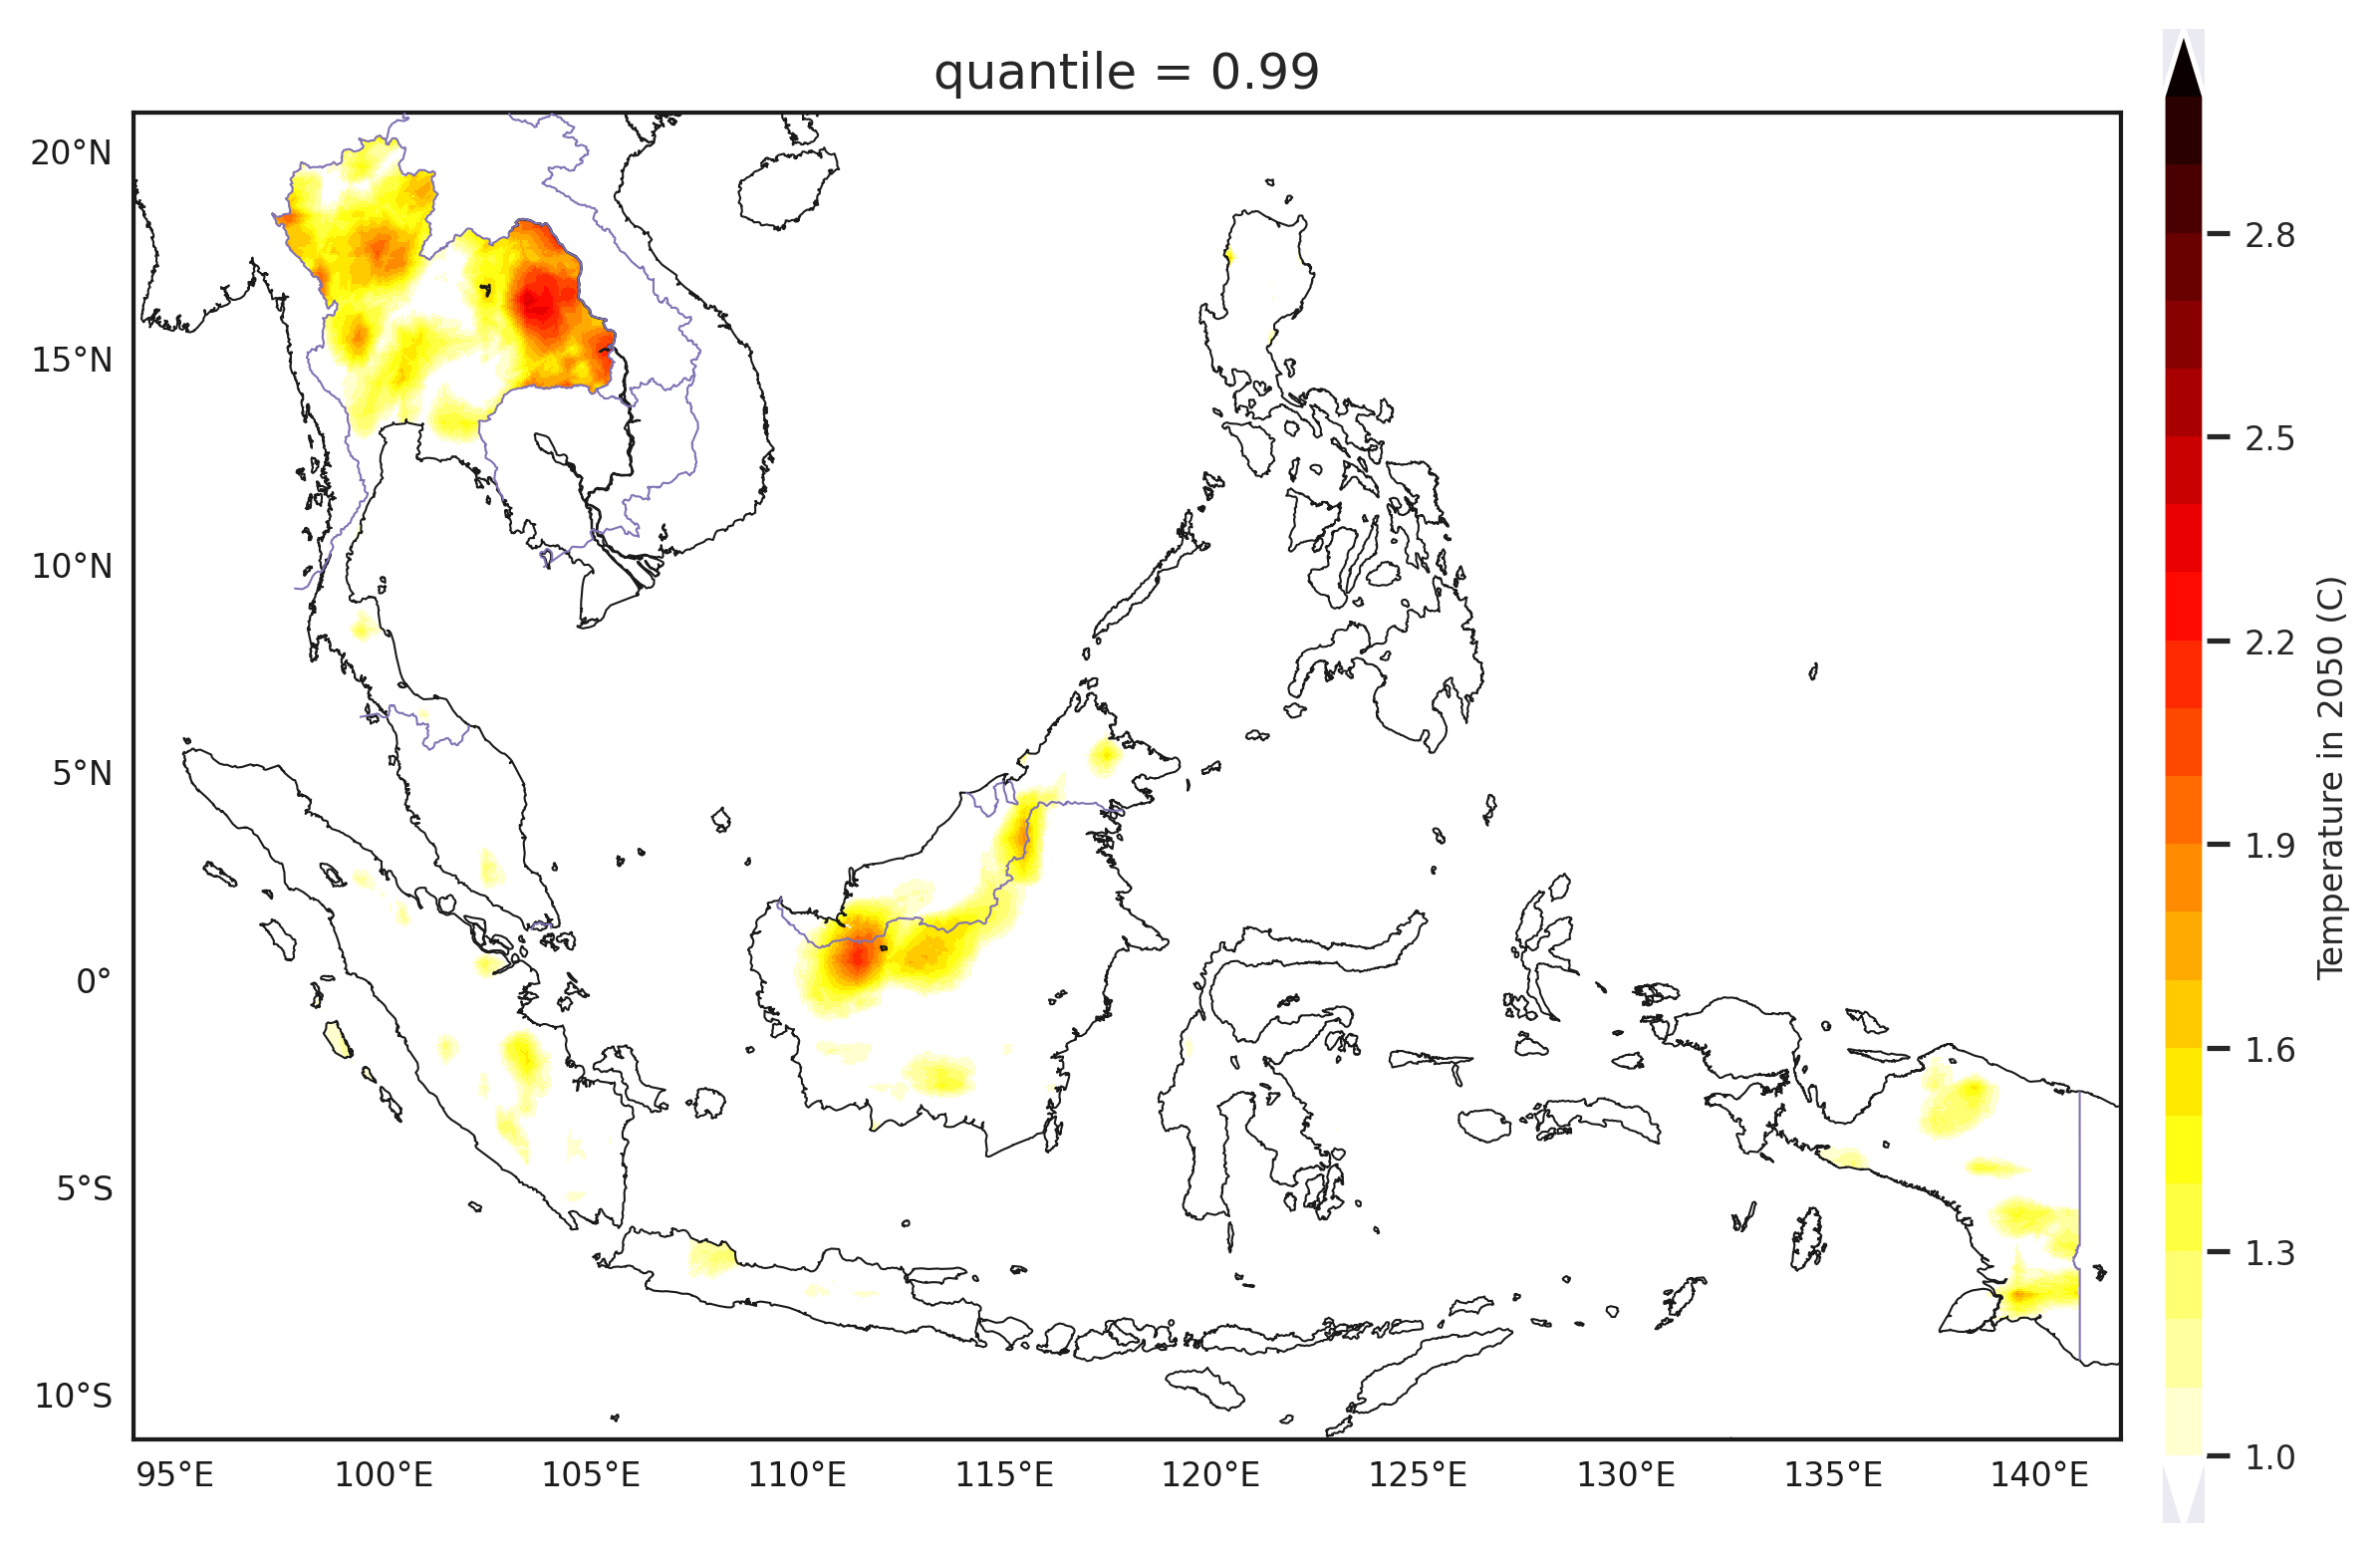

In [108]:
import xarray as xr
from   mpl_toolkits.basemap    import Basemap
from   matplotlib              import gridspec
from   matplotlib.colorbar     import Colorbar


fig,ax=plt.subplots(1,1); fig.set_size_inches(7,5); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(300); 
fig.subplots_adjust(left=0.00, right=0.95, top=1., bottom=0.0, wspace=0.4,hspace=0.3); fontsize = 8

gs0  = gridspec.GridSpec(1, 1)
gs0.update(left=0.97, right=0.99, bottom=0.00, top=1., hspace=0.06, wspace=0.1)
bx = plt.subplot(gs0[0, 0])

m = Basemap(projection='cyl', llcrnrlat=-11, urcrnrlat=21,llcrnrlon=94, urcrnrlon=142,resolution='i',ax=ax)
_ = m.drawcoastlines(linewidth=.5,color='k',zorder=10)
_ = m.drawcountries(linewidth=.5,color='m',zorder=10)
_ = m.drawmapboundary(fill_color='w')
_ = m.fillcontinents(color='none',lake_color='none')
_ = m.drawmeridians(np.arange(0,361,5),labels=[0,0,0,1],linewidth=0.,fontsize=fontsize)
_ = m.drawparallels(np.arange(-40,61,5),labels=[1,0,0,0],linewidth=0.,fontsize=fontsize)

for C_NAME in ['Malaysia','Philippines','Thailand','Indonesia']:
    
    predicted = xr.open_dataset('./OUTPUT/TEMP_'+C_NAME+'_5km_2050.nc')
    nowdays   = xr.open_dataset('./OUTPUT/TEMP_'+C_NAME+'_5km_NOW.nc')
    
    countries_select = countries[countries.NAME_0==C_NAME].geometry

    countries_mask_poly = regionmask.Regions(name = 'NAME_0', outlines = list(countries_select.geometry.values[i] for i in range(0,countries_select.shape[0])))

    mask = countries_mask_poly.mask(predicted.isel(time = 0), lat_name='lat', lon_name='lon')

    # tmp_var = predicted.mean('time')-nowdays.mean('time')
    tmp_var = predicted.quantile(0.99, dim="time")-nowdays.quantile(0.99, dim="time")
    ### we can smooth the output but will lose details
    # for SMOOTH in range(1):
    #     tmp_var = tmp_var.rolling(lat=10,lon=10, center=True, min_periods=1).mean()
    tmp_var = tmp_var.where(~np.isnan(mask))
    
    c=tmp_var.__xarray_dataarray_variable__.plot(ax=ax,cmap='hot_r',levels=np.linspace(1,3,21),extend='both',add_colorbar=False,facecolor="white")
    if C_NAME == 'Malaysia':
        cb = Colorbar(ax = bx, mappable = c,orientation = 'vertical', ticklocation = 'right')
        cb.set_label('Temperature in 2050 (C)', labelpad=5,fontsize=fontsize)
        cb.ax.tick_params(labelsize=fontsize)        
        
    _=countries_select.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 0.)
    _=ax.set_xlim(94,142)
    _=ax.set_ylim(-11,21)
    _=ax.set_xlabel('')
    _=ax.set_ylabel('')

plt.savefig('/home/sw1013/www/FIGURES/SIG_TEMP.png',dpi=600,bbox_inches='tight')

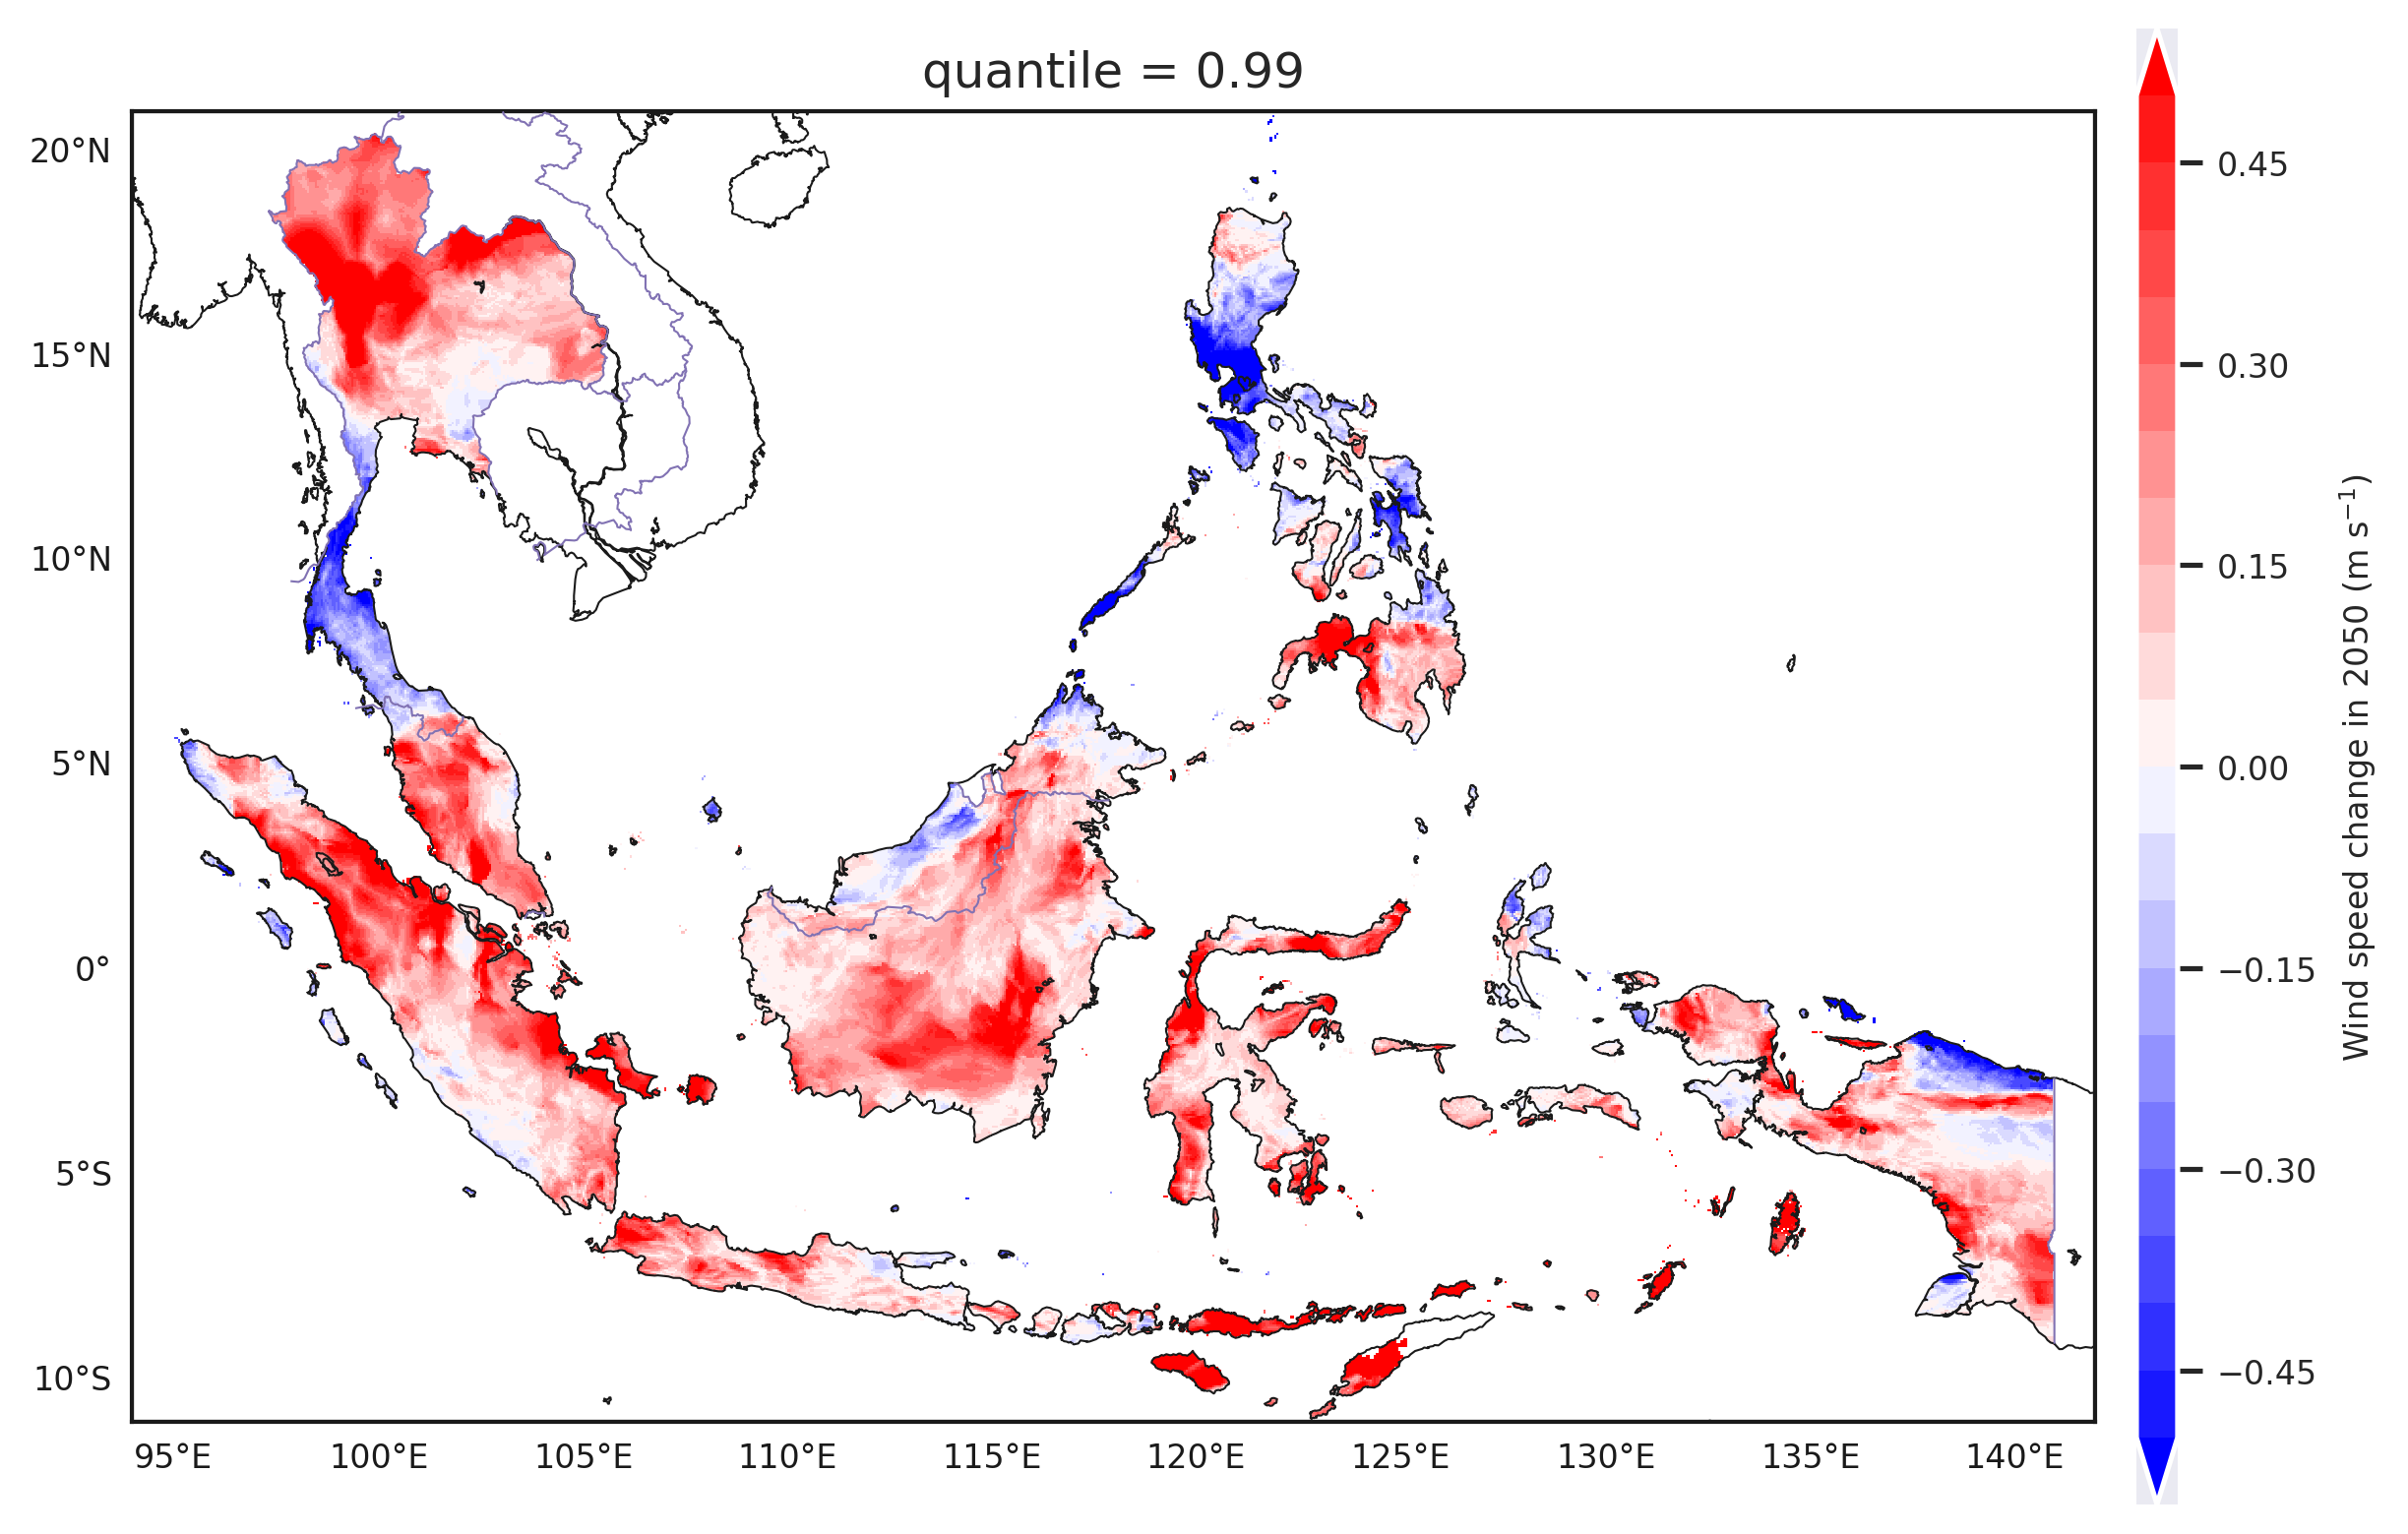

In [109]:
import xarray as xr
from   mpl_toolkits.basemap    import Basemap
from   matplotlib              import gridspec
from   matplotlib.colorbar     import Colorbar


fig,ax=plt.subplots(1,1); fig.set_size_inches(7,5); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(300); 
fig.subplots_adjust(left=0.00, right=0.95, top=1., bottom=0.0, wspace=0.4,hspace=0.3); fontsize = 8

gs0  = gridspec.GridSpec(1, 1)
gs0.update(left=0.97, right=0.99, bottom=0.00, top=1., hspace=0.06, wspace=0.1)
bx = plt.subplot(gs0[0, 0])

m = Basemap(projection='cyl', llcrnrlat=-11, urcrnrlat=21,llcrnrlon=94, urcrnrlon=142,resolution='i',ax=ax)
_ = m.drawcoastlines(linewidth=.5,color='k',zorder=10)
_ = m.drawcountries(linewidth=.5,color='m',zorder=10)
_ = m.drawmapboundary(fill_color='w')
_ = m.fillcontinents(color='none',lake_color='none')
_ = m.drawmeridians(np.arange(0,361,5),labels=[0,0,0,1],linewidth=0.,fontsize=fontsize)
_ = m.drawparallels(np.arange(-40,61,5),labels=[1,0,0,0],linewidth=0.,fontsize=fontsize)

for C_NAME in ['Malaysia','Philippines','Thailand','Indonesia']:
    
    predicted = xr.open_dataset('./OUTPUT/WIND_'+C_NAME+'_5km_2050.nc')
    nowdays   = xr.open_dataset('./OUTPUT/WIND_'+C_NAME+'_5km_NOW.nc')
    
    countries_select = countries[countries.NAME_0==C_NAME].geometry

    countries_mask_poly = regionmask.Regions(name = 'NAME_0', outlines = list(countries_select.geometry.values[i] for i in range(0,countries_select.shape[0])))

    mask = countries_mask_poly.mask(predicted.isel(time = 0), lat_name='lat', lon_name='lon')

    # tmp_var = predicted.mean('time')-nowdays.mean('time')
    tmp_var = predicted.quantile(0.99, dim="time")-nowdays.quantile(0.99, dim="time")
    ### we can smooth the output but will lose details
    # for SMOOTH in range(1):
    #     tmp_var = tmp_var.rolling(lat=10,lon=10, center=True, min_periods=1).mean()
    tmp_var = tmp_var.where(~np.isnan(mask))
    
    c=tmp_var.__xarray_dataarray_variable__.plot(ax=ax,cmap='bwr',levels=np.linspace(-.5,.5,21),extend='both',add_colorbar=False,facecolor="white")
    if C_NAME == 'Malaysia':
        cb = Colorbar(ax = bx, mappable = c,orientation = 'vertical', ticklocation = 'right')
        cb.set_label('Wind speed change in 2050 (m s$^{-1}$)', labelpad=5,fontsize=fontsize)
        cb.ax.tick_params(labelsize=fontsize)        
        
    _=countries_select.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 0.)
    _=ax.set_xlim(94,142)
    _=ax.set_ylim(-11,21)
    _=ax.set_xlabel('')
    _=ax.set_ylabel('')

plt.savefig('/home/sw1013/www/FIGURES/SIG_WIND.png',dpi=600,bbox_inches='tight')

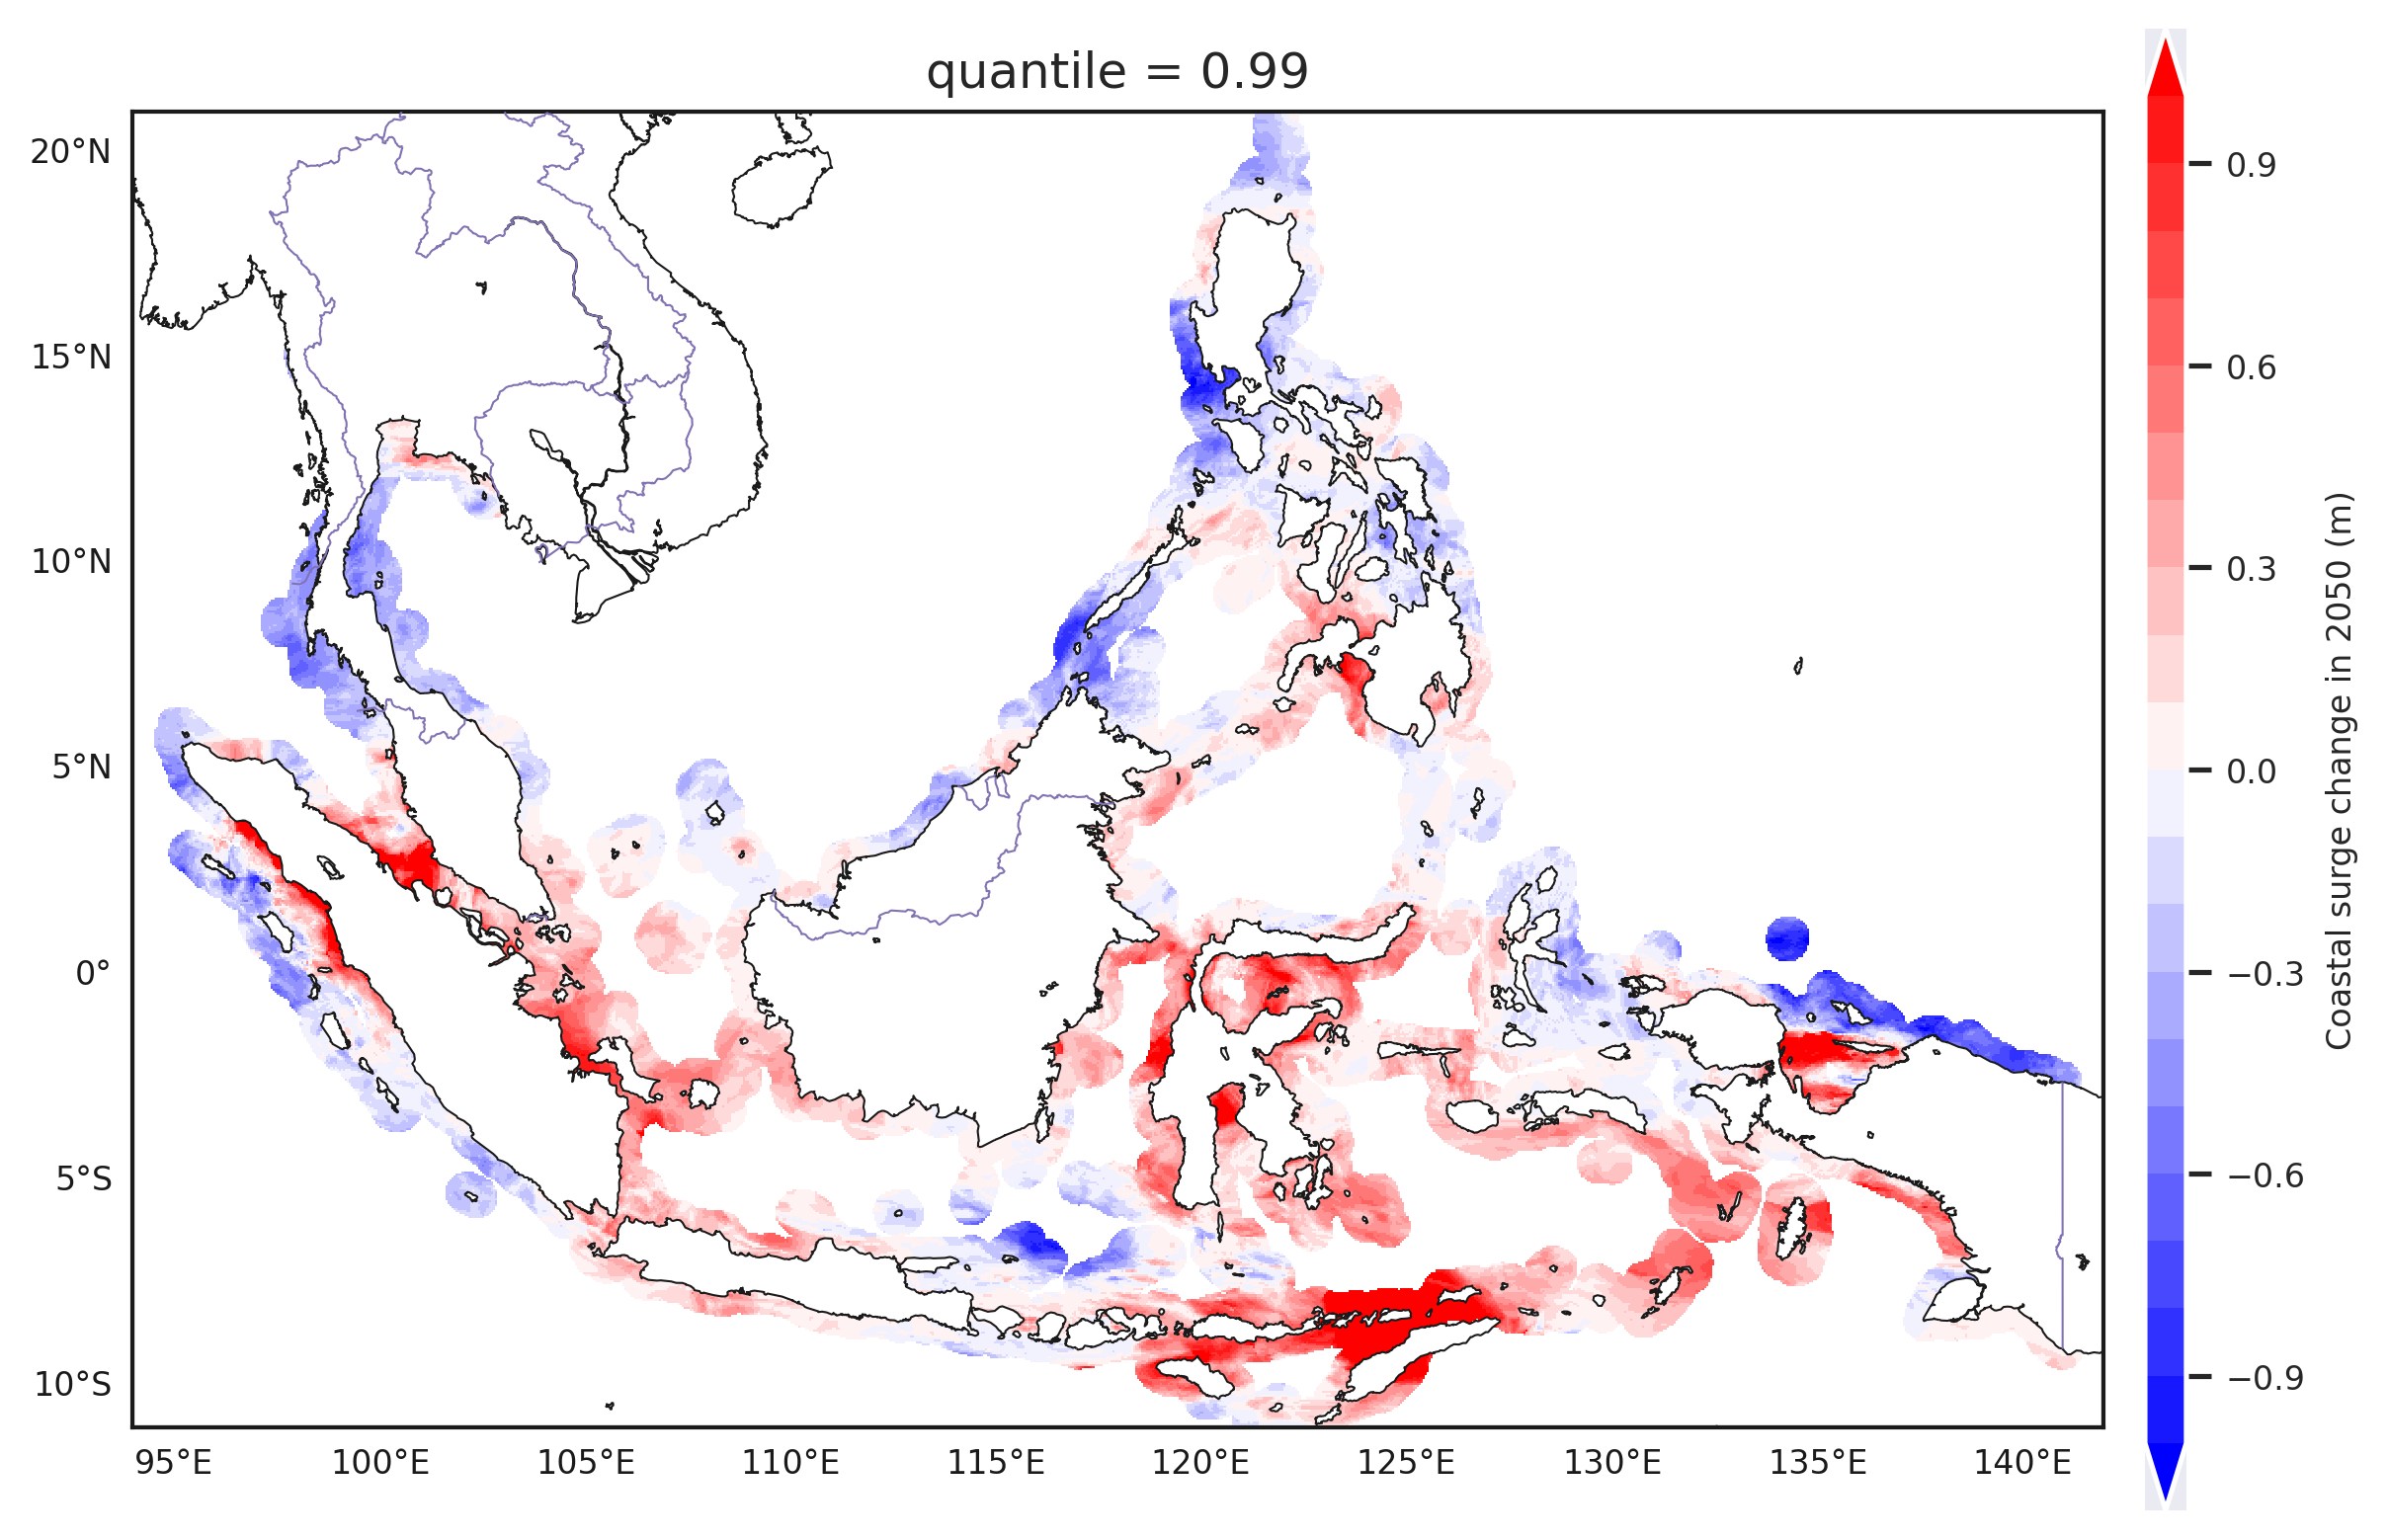

In [110]:
import xarray as xr
from   mpl_toolkits.basemap    import Basemap
from   matplotlib              import gridspec
from   matplotlib.colorbar     import Colorbar


fig,ax=plt.subplots(1,1); fig.set_size_inches(7,5); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(300); 
fig.subplots_adjust(left=0.00, right=0.95, top=1., bottom=0.0, wspace=0.4,hspace=0.3); fontsize = 8

gs0  = gridspec.GridSpec(1, 1)
gs0.update(left=0.97, right=0.99, bottom=0.00, top=1., hspace=0.06, wspace=0.1)
bx = plt.subplot(gs0[0, 0])

m = Basemap(projection='cyl', llcrnrlat=-11, urcrnrlat=21,llcrnrlon=94, urcrnrlon=142,resolution='i',ax=ax)
_ = m.drawcoastlines(linewidth=.5,color='k',zorder=10)
_ = m.drawcountries(linewidth=.5,color='m',zorder=10)
_ = m.drawmapboundary(fill_color='w')
_ = m.fillcontinents(color='white',lake_color='none')
_ = m.drawmeridians(np.arange(0,361,5),labels=[0,0,0,1],linewidth=0.,fontsize=fontsize)
_ = m.drawparallels(np.arange(-40,61,5),labels=[1,0,0,0],linewidth=0.,fontsize=fontsize)

for C_NAME in ['Malaysia','Philippines','Thailand','Indonesia']:
    
    predicted = xr.open_dataset('./OUTPUT/WIND_'+C_NAME+'_5km_2050.nc')
    nowdays   = xr.open_dataset('./OUTPUT/WIND_'+C_NAME+'_5km_NOW.nc')
    
    # countries_select = countries[countries.NAME_0==C_NAME].geometry
    countries_select = countries[countries.NAME_0==C_NAME].geometry.buffer(.5)

    countries_mask_poly = regionmask.Regions(name = 'NAME_0', outlines = list(countries_select.geometry.values[i] for i in range(0,countries_select.shape[0])))

    mask = countries_mask_poly.mask(predicted.isel(time = 0), lat_name='lat', lon_name='lon')

    # tmp_var = predicted.mean('time')-nowdays.mean('time')
    tmp_var = (predicted.quantile(0.99, dim="time") / nowdays.quantile(0.99, dim="time") - 1.) * 42. * ((5.5-1.5)/(69-42))
    # tmp_var = (predicted.mean("time") / nowdays.mean("time") - 1.) * 42. * ((5.5-1.5)/(69-42))
    ### we can smooth the output but will lose details
    # for SMOOTH in range(1):
    #     tmp_var = tmp_var.rolling(lat=10,lon=10, center=True, min_periods=1).mean()
    tmp_var = tmp_var.where(~np.isnan(mask))
    
    c=tmp_var.__xarray_dataarray_variable__.plot(ax=ax,cmap='bwr',levels=np.linspace(-1,1.,21),extend='both',add_colorbar=False,facecolor="white")
    if C_NAME == 'Malaysia':
        cb = Colorbar(ax = bx, mappable = c,orientation = 'vertical', ticklocation = 'right')
        cb.set_label('Coastal surge change in 2050 (m)', labelpad=5,fontsize=fontsize)
        cb.ax.tick_params(labelsize=fontsize)        
        
    _=countries_select.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 0.)
    _=ax.set_xlim(94,142)
    _=ax.set_ylim(-11,21)
    _=ax.set_xlabel('')
    _=ax.set_ylabel('')

plt.savefig('/home/sw1013/www/FIGURES/SIG_WIND.png',dpi=600,bbox_inches='tight')

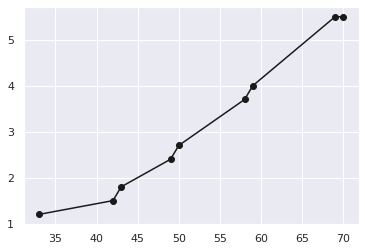

In [92]:
V = [ 33,  42, 43, 49, 50, 58, 59, 69, 70]
S = [1.2, 1.5,1.8,2.4,2.7,3.7,4.0,5.5,5.5]
plt.plot(V,S,'-ok')

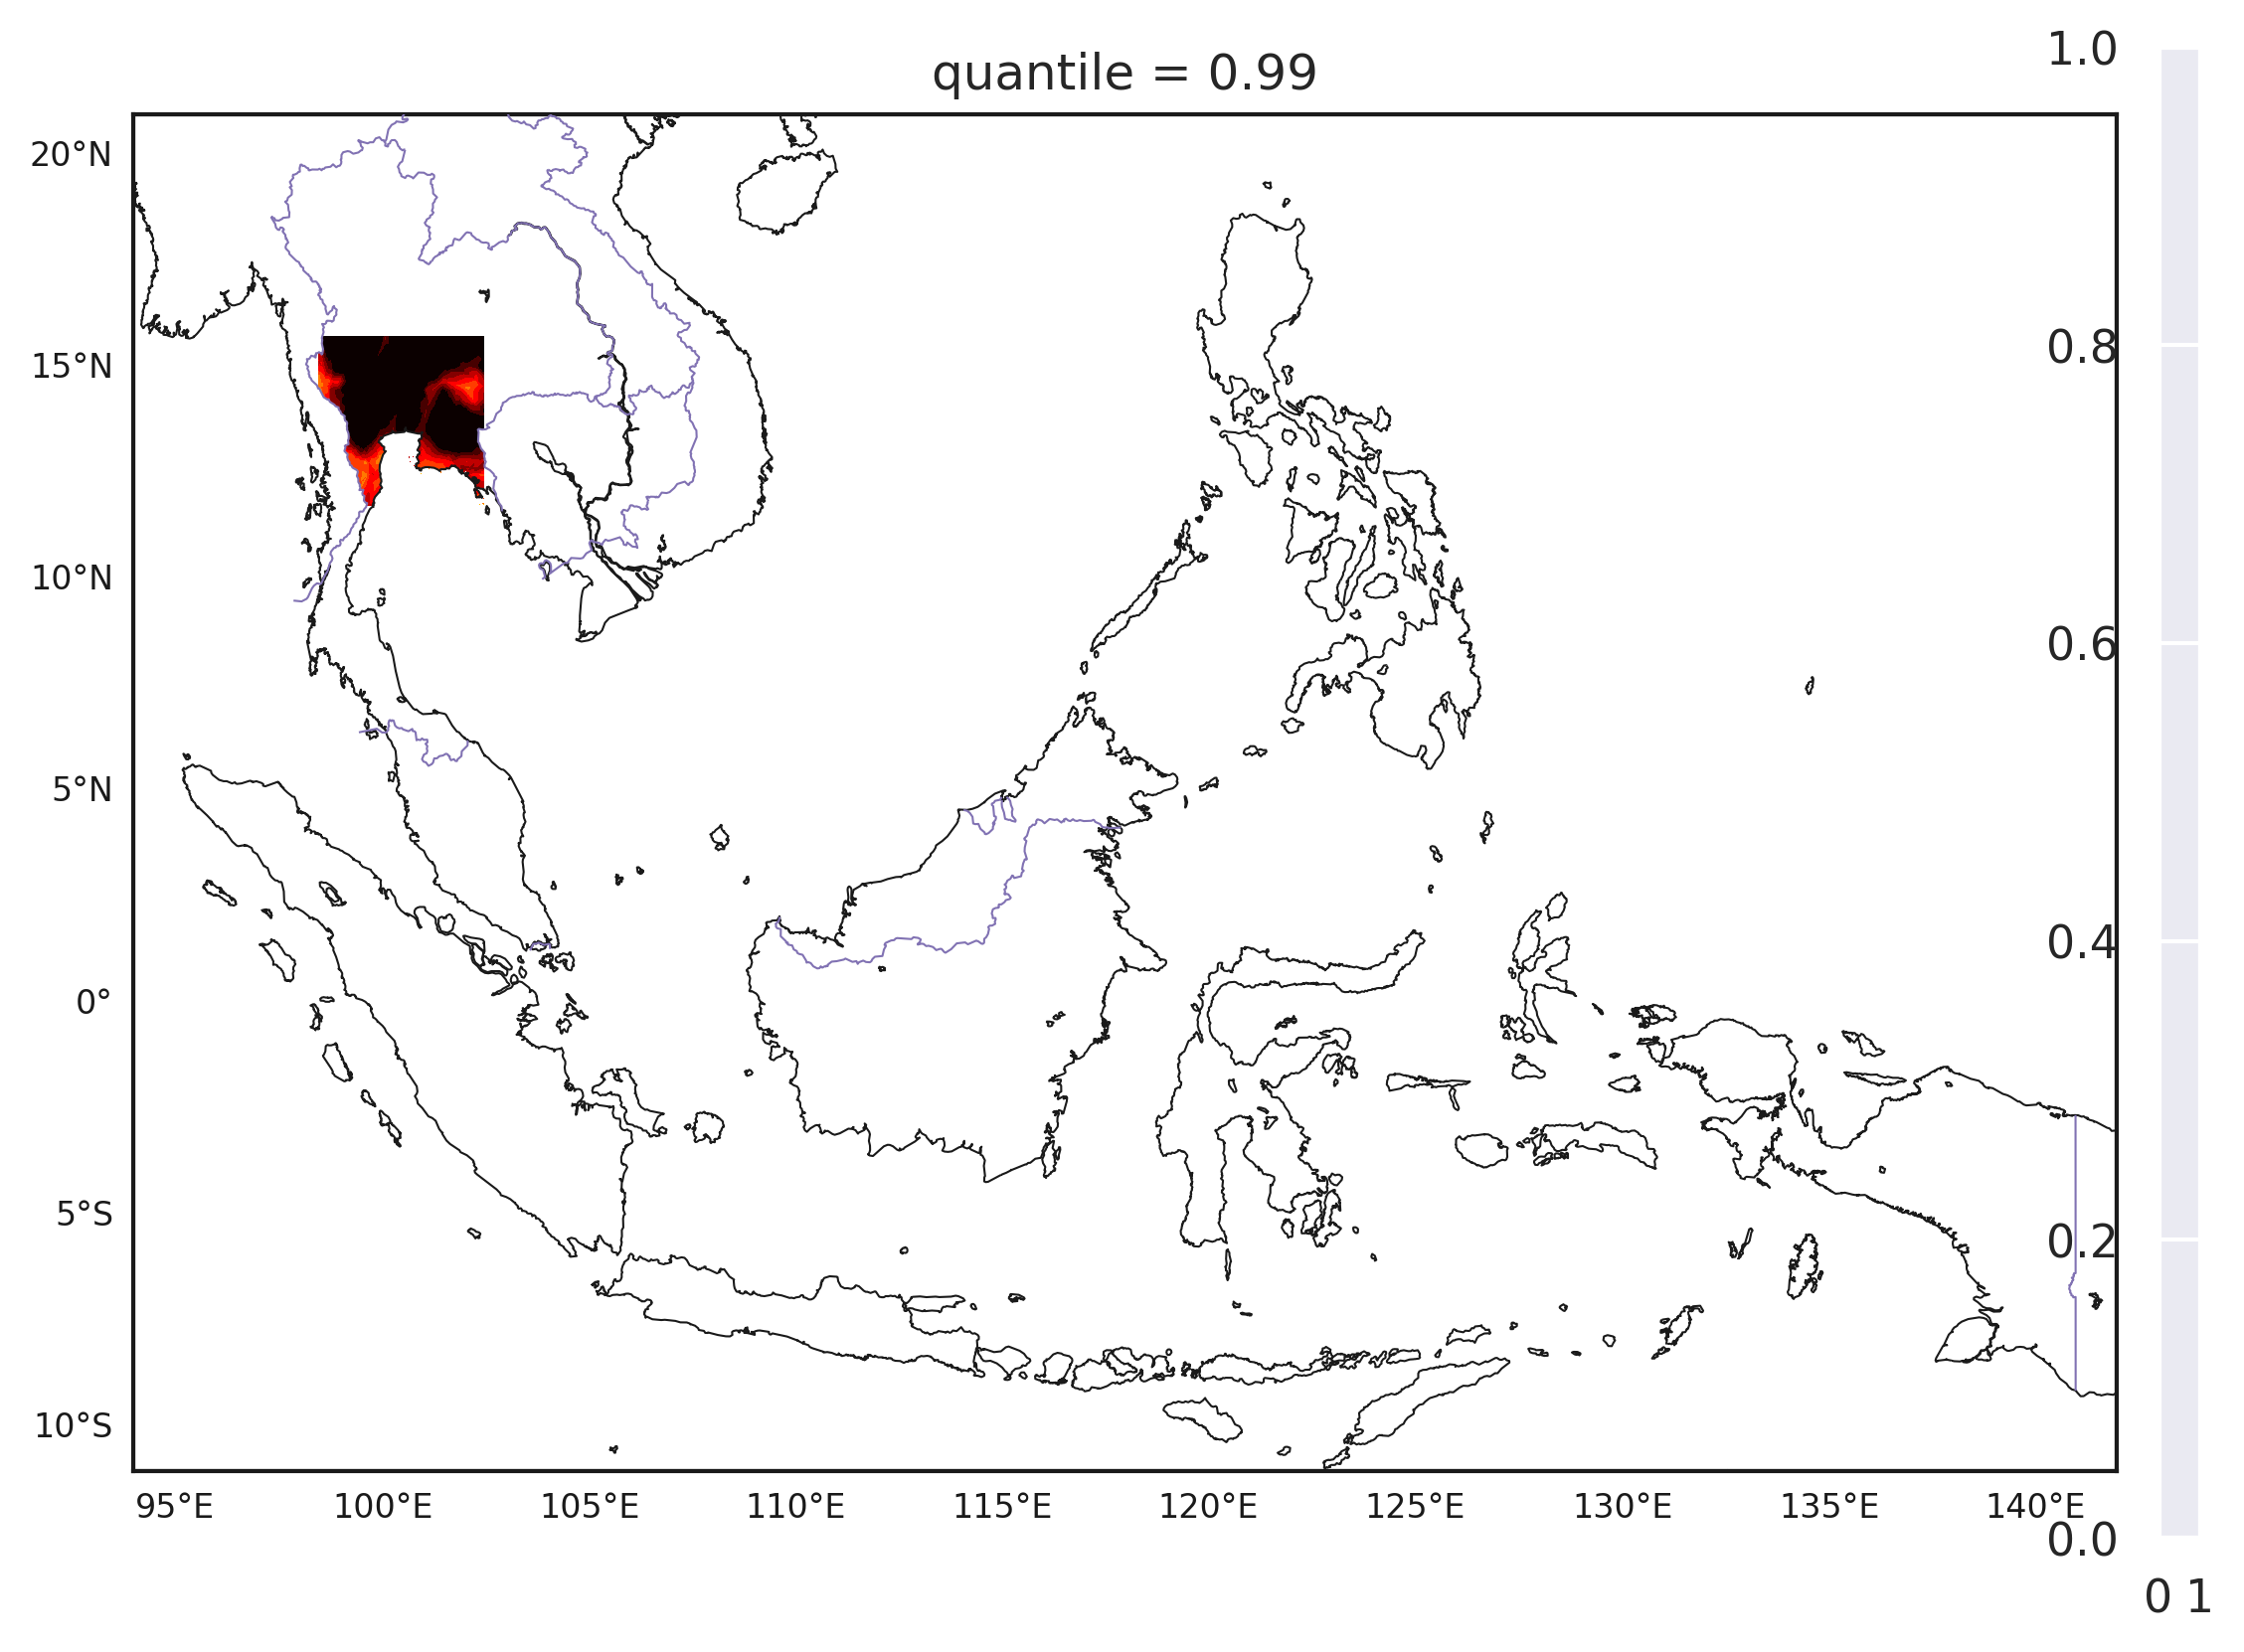

In [4]:
import xarray as xr
from   mpl_toolkits.basemap    import Basemap
from   matplotlib              import gridspec
from   matplotlib.colorbar     import Colorbar


fig,ax=plt.subplots(1,1); fig.set_size_inches(7,5); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(300); 
fig.subplots_adjust(left=0.00, right=0.95, top=1., bottom=0.0, wspace=0.4,hspace=0.3); fontsize = 8

gs0  = gridspec.GridSpec(1, 1)
gs0.update(left=0.97, right=0.99, bottom=0.00, top=1., hspace=0.06, wspace=0.1)
bx = plt.subplot(gs0[0, 0])

m = Basemap(projection='cyl', llcrnrlat=-11, urcrnrlat=21,llcrnrlon=94, urcrnrlon=142,resolution='i',ax=ax)
_ = m.drawcoastlines(linewidth=.5,color='k',zorder=10)
_ = m.drawcountries(linewidth=.5,color='m',zorder=10)
_ = m.drawmapboundary(fill_color='w')
_ = m.fillcontinents(color='none',lake_color='none')
_ = m.drawmeridians(np.arange(0,361,5),labels=[0,0,0,1],linewidth=0.,fontsize=fontsize)
_ = m.drawparallels(np.arange(-40,61,5),labels=[1,0,0,0],linewidth=0.,fontsize=fontsize)


C_NAME = 'KUALA_LUMPUR'
COUNTRY = 'Malaysia'   #'Malaysia','Philippines','Thailand','Indonesia'

C_NAME = 'BANGKOK'
COUNTRY = 'Thailand'  #'Malaysia','Philippines','Thailand','Indonesia'
    
predicted = xr.open_dataset('./OUTPUT/TEMP_'+C_NAME+'_1km_2050.nc')
nowdays   = xr.open_dataset('./OUTPUT/TEMP_'+C_NAME+'_1km_NOW.nc')

countries_select = countries[countries.NAME_0==COUNTRY].geometry

countries_mask_poly = regionmask.Regions(name = 'NAME_0', outlines = list(countries_select.geometry.values[i] for i in range(0,countries_select.shape[0])))

mask = countries_mask_poly.mask(predicted.isel(time = 0), lat_name='lat', lon_name='lon')

# tmp_var = predicted.mean('time')-nowdays.mean('time')
tmp_var = predicted.quantile(0.99, dim="time")-nowdays.quantile(0.99, dim="time")
### we can smooth the output but will lose details
# for SMOOTH in range(1):
#     tmp_var = tmp_var.rolling(lat=10,lon=10, center=True, min_periods=1).mean()
tmp_var = tmp_var.where(~np.isnan(mask))

c=tmp_var.__xarray_dataarray_variable__.plot(ax=ax,cmap='hot_r',levels=np.linspace(0,1,11),extend='both',add_colorbar=False,facecolor="white")
if C_NAME == 'Malaysia':
    cb = Colorbar(ax = bx, mappable = c,orientation = 'vertical', ticklocation = 'right')
    cb.set_label('Temperature in 2050 (C)', labelpad=5,fontsize=fontsize)
    cb.ax.tick_params(labelsize=fontsize)        

_=countries_select.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 0.)
_=ax.set_xlim(94,142)
_=ax.set_ylim(-11,21)
_=ax.set_xlabel('')
_=ax.set_ylabel('')

